# 1. 產生 GaussPy 擬合所需的像素光譜輸入檔

In [ ]:
def prepare_gausspy_input_per_pixel(
    cube_file, v1, v2, x1, x2, y1, y2, output_pickle='spectrum_for_gausspy.pickle'
):
    import numpy as np
    import pickle
    from astropy.io import fits

    # 讀取 FITS 資料
    data = fits.getdata(cube_file)[0]
    header = fits.getheader(cube_file)
    subcube = data[v1:v2, y1:y2, x1:x2]  # shape: (channels, y, x)

    # 頻道 → 速度（radio convention）
    CRVAL3 = header['CRVAL3']
    CDELT3 = header['CDELT3']
    CRPIX3 = header['CRPIX3']
    N_full = header['NAXIS3']

    chan_all = np.arange(N_full)
    velo_all = CRVAL3 + (chan_all + 1 - CRPIX3) * CDELT3  # m/s
    velo_all_kms = velo_all / 1e3 # 將速度轉換為 km/s
    velo = velo_all_kms[v1:v2]

    # 每個 pixel 一條光譜
    ny, nx = subcube.shape[1:]
    spectra_list = []
    errors_list = []

    for j in range(ny):
        for i in range(nx):
            spec = subcube[:, j, i]
            rms = np.nanstd(spec)
            spectra_list.append(spec)
            errors_list.append(np.full_like(spec, rms))

    # 儲存為 GaussPy 輸入格式
    output = {
        'x_values': [velo] * len(spectra_list),
        'data_list': spectra_list,
        'errors': errors_list
    }

    with open(output_pickle, 'wb') as f:
        pickle.dump(output, f)

    print(f"✅ 已儲存 {len(spectra_list)} 條光譜至 {output_pickle}")

prepare_gausspy_input_per_pixel(
    cube_file="../datacubes/spw0.fits",
    v1=750, v2=950, x1=220, x2=240, y1=100, y2=120,
    output_pickle='spectrum_for_gausspy.pickle'
)

# 2. 執行 GaussPy phase two 雙階段高斯分解

In [ ]:
def run_phase_two_gausspy_decomposition(
    input_pickle='spectrum_for_gausspy.pickle',
    output_pickle='gausspy_result.pickle',
    alpha1=2.0,
    alpha2=6.0,
    snr_thresh=3.0
):
    import pickle
    from gausspy.gp import GaussianDecomposer

    # 初始化
    g = GaussianDecomposer()

    # 設定為雙階段模式
    g.set('phase', 'two')
    g.set('alpha1', alpha1)
    g.set('alpha2', alpha2)
    g.set('SNR_thresh', [snr_thresh, snr_thresh])

    # 執行分解
    print("🚀 執行 GaussPy phase='two' 分解 ...")
    result = g.batch_decomposition(input_pickle)

    # 儲存結果
    with open(output_pickle, 'wb') as f:
        pickle.dump(result, f)

    print(f'雙階段分解完成，儲存為 {output_pickle}')
    print(f'可用欄位：{list(result.keys())}')

run_phase_two_gausspy_decomposition(
    input_pickle='spectrum_for_gausspy.pickle',
    output_pickle='gausspy_result.pickle',
    alpha1=2.0,
    alpha2=6.0,
    snr_thresh=3.0
)


# 3. 統計 GaussPy 擬合成功與失敗數量

In [ ]:
def count_successful_gausspy_fits(
    result_pickle='gausspy_result.pickle',
    subcube_shape=None  # 例如 (ny, nx)，可選，用來還原失敗像素的空間座標
):
    import pickle

    with open(result_pickle, 'rb') as f:
        result = pickle.load(f)

    # 使用預設欄位 amplitudes_fit
    if 'amplitudes_fit' not in result:
        raise KeyError("❌ 找不到 'amplitudes_fit' 欄位，請確認輸入是 GaussPy 的結果")

    amps_all = result['amplitudes_fit']
    n_total = len(amps_all)
    failed_indices = [i for i, amps in enumerate(amps_all) if amps is None or len(amps) == 0]
    n_success = n_total - len(failed_indices)
    success_rate = 100 * n_success / n_total if n_total > 0 else 0

    print(f"🔍 擬合總數：{n_total}，成功數：{n_success}，失敗數：{len(failed_indices)}")
    print(f"✅ 成功率：{success_rate:.1f}%")

    if failed_indices:
        print(f"❌ 失敗 index 共 {len(failed_indices)} 筆")
        if subcube_shape:
            ny, nx = subcube_shape
            failed_coords = [(i // nx, i % nx) for i in failed_indices]
            print("失敗座標 (y, x):")
            for yx in failed_coords:
                print(f" - {yx}")
            return failed_coords
        else:
            print(f"失敗 index: {failed_indices}")
            return failed_indices
    else:
        print("🎉 所有像素擬合成功！")
        return []
        
count_successful_gausspy_fits(
    result_pickle='gausspy_result.pickle',
    subcube_shape=(20, 20)  # 根據 prepare_gausspy_input_per_pixel 的輸入設定
)

# 4. 繪製 GaussPy 擬合結果（每條光譜）

In [ ]:
def plot_gausspy_fits(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    max_plots=None,
    dpi=100
):
    """
    一張一張畫出 GaussPy 擬合結果，標出每個高斯成分的 peak velocity。
    僅使用一般擬合結果（不含 EM fit）。
    """
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt

    with open(data_pickle, 'rb') as f:
        data = pickle.load(f)
    with open(result_pickle, 'rb') as f:
        result = pickle.load(f)

    x_all = data['x_values']
    y_all = data['data_list']
    amps_all = result['amplitudes_fit']
    means_all = result['means_fit']
    fwhms_all = result['fwhms_fit']

    n_result = len(amps_all)
    n_data = len(y_all)
    n_total = min(n_result, n_data)
    n_plotted = 0

    for i in range(n_total):
        if max_plots is not None and n_plotted >= max_plots:
            break

        amps = amps_all[i]
        means = means_all[i]
        fwhms = fwhms_all[i]

        if amps is None or len(amps) == 0:
            continue  # 擬合失敗，跳過

        x = x_all[i]
        y = y_all[i]
        stddevs = fwhms / (2 * np.sqrt(2 * np.log(2)))

        fit_total = np.zeros_like(x)
        gaussians = []

        for amp, mean, std in zip(amps, means, stddevs):
            gauss = amp * np.exp(-(x - mean)**2 / (2 * std**2))
            fit_total += gauss
            gaussians.append((gauss, mean, amp))

        # 繪圖
        plt.figure(figsize=(10, 4), dpi=dpi)
        plt.plot(x, y, color='black', lw=1, label='Original Spectrum')
        plt.plot(x, fit_total, color='red', lw=2, label='Total Fit')

        colors = plt.cm.tab10(np.linspace(0, 1, len(gaussians)))

        for j, (g, mean, amp) in enumerate(gaussians):
            plt.plot(x, g, linestyle='--', color=colors[j % 10], alpha=0.8, label=f'Comp {j+1}')
            plt.axvline(mean, color=colors[j % 10], linestyle='-', linewidth=1)
            plt.text(mean, amp * 1.05, f'v = {mean:.1f} km/s',
                     rotation=90, ha='center', va='bottom', fontsize=8,
                     color=colors[j % 10], backgroundcolor='white')

        plt.title(f'Gaussian Fit - Spectrum #{i}', fontsize=12)
        plt.xlabel('Velocity (km/s)')
        plt.ylabel('Intensity')
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.legend(fontsize=8, loc='upper right')
        plt.tight_layout()
        plt.show()

        n_plotted += 1

    print(f"✅ 已繪製 {n_plotted} 條擬合成功的光譜（標記 peak velocity）")

plot_gausspy_fits(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    max_plots=10,  # 限制繪製前 10 條光譜
    dpi=100
)

# 5. 將所有fit出的光譜移到rest frame 上並畫出

In [ ]:
def plot_gausspy_fits_all_restframe(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    max_plots=None,
    dpi=100
):
    """
    一張一張畫出 spectrum 的擬合結果，並將主成分 peak 對齊至 v = 0 km/s。
    """
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt

    with open(data_pickle, 'rb') as f:
        data = pickle.load(f)
    with open(result_pickle, 'rb') as f:
        result = pickle.load(f)

    x_all = data['x_values']
    y_all = data['data_list']
    amps_all = result['amplitudes_fit']
    means_all = result['means_fit']
    fwhms_all = result['fwhms_fit']

    n_result = len(amps_all)
    n_data = len(y_all)
    n_total = min(n_result, n_data)
    n_plotted = 0

    for i in range(n_total):
        if max_plots is not None and n_plotted >= max_plots:
            break

        amps = amps_all[i]
        means = means_all[i]
        fwhms = fwhms_all[i]

        if amps is None or len(amps) == 0:
            continue

        x_orig = x_all[i]
        y = y_all[i]

        # 取第一個成分的 peak velocity 當作 rest frame 參考
        v_peak = means[0]
        x_shifted = x_orig - v_peak
        means_shifted = [v - v_peak for v in means]

        stddevs = fwhms / (2 * np.sqrt(2 * np.log(2)))

        fit_total = np.zeros_like(x_orig)
        gaussians = []

        for amp, mean, std in zip(amps, means_shifted, stddevs):
            gauss = amp * np.exp(-(x_shifted - mean)**2 / (2 * std**2))
            fit_total += gauss
            gaussians.append((gauss, mean, amp))

        # 畫圖
        plt.figure(figsize=(10, 4), dpi=dpi)
        plt.plot(x_shifted, y, color='black', lw=1, label='Original Spectrum')
        plt.plot(x_shifted, fit_total, color='red', lw=2, label='Total Fit')

        colors = plt.cm.tab10(np.linspace(0, 1, len(gaussians)))

        for j, (g, mean, amp) in enumerate(gaussians):
            plt.plot(x_shifted, g, linestyle='--', color=colors[j % 10], alpha=0.8, label=f'Comp {j+1}')
            plt.axvline(mean, color=colors[j % 10], linestyle='-', linewidth=1)
            plt.text(mean, amp * 1.05, f'{mean:.1f} km/s',
                     rotation=90, ha='center', va='bottom', fontsize=8,
                     color=colors[j % 10], backgroundcolor='white')

        plt.title(f'Gaussian Fit (Rest Frame) - Spectrum #{i}', fontsize=12)
        plt.xlabel('Rest-frame Velocity (km/s)')
        plt.ylabel('Intensity')
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.legend(fontsize=8, loc='upper right')
        plt.tight_layout()
        plt.show()

        n_plotted += 1

    print(f"✅ 已繪製 {n_plotted} 條光譜（主 peak 對齊 v = 0 km/s）")

# plot_gausspy_fits_all_restframe(
#     data_pickle='spectrum_for_gausspy.pickle',
#     result_pickle='gausspy_result.pickle',
#     max_plots=10,  # 限制繪製前 10 條光譜
#     dpi=100
# )

# 6. 將主成分移到rest frame 上並疊加

/Users/ccc/opt/anaconda3/envs/gausspy/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
/Users/ccc/opt/anaconda3/envs/gausspy/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


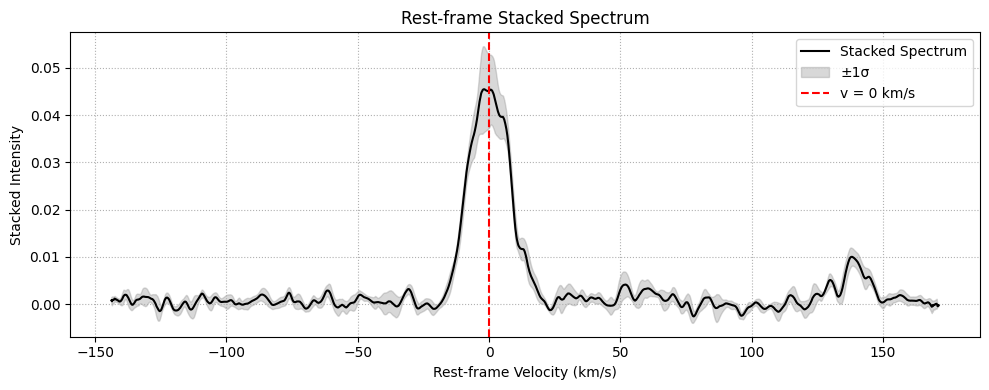

✅ 疊加完成：總光譜 25，成功使用 23 條（92.0%）


In [ ]:
def stack_restframe_spectra(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    velocity_grid=None,
    v_range=(-50, 50),
    dv=0.2,
    normalize=False
):
    """
    疊加所有擬合成功的光譜，將主成分對齊至 v=0 km/s，提升 SNR。

    參數：
        data_pickle: 光譜資料（prepare_gausspy_input 的輸出）
        result_pickle: GaussPy 的分解結果（run_phase_two_gausspy_decomposition 的輸出）
        velocity_grid: 自訂統一速度軸（若為 None 則使用 v_range 與 dv 建立）
        v_range: 預設速度範圍 (km/s)，如 (-50, 50)
        dv: 速度解析度 (km/s)
        normalize: 是否正規化每條光譜再進行疊加（避免個別強度主導）

    回傳：
        v_grid: 速度軸 (km/s)
        mean_spec: 疊加平均光譜
        std_spec: 疊加標準差（1σ）
    """
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import interp1d

    # === 讀入光譜與擬合資料 ===
    with open(data_pickle, 'rb') as f:
        data = pickle.load(f)
    with open(result_pickle, 'rb') as f:
        result = pickle.load(f)

    x_all = data['x_values']
    y_all = data['data_list']
    amps_all = result['amplitudes_fit']
    means_all = result['means_fit']

    # === 定義統一速度軸 ===
    if velocity_grid is None:
        v_grid = np.arange(v_range[0], v_range[1] + dv, dv)
    else:
        v_grid = velocity_grid

    stacked = []
    used_indices = []

    for i, (x, y, amps, means) in enumerate(zip(x_all, y_all, amps_all, means_all)):
        if amps is None or len(amps) == 0 or means is None:
            continue

        # 使用最大 amplitude 對應的中心作為平移基準
        idx_peak = np.argmax(amps)
        v_peak = means[idx_peak]
        x_shifted = x - v_peak  # 主成分對齊到 v = 0

        try:
            f_interp = interp1d(x_shifted, y, kind='linear', bounds_error=False, fill_value=np.nan)
            y_interp = f_interp(v_grid)
            if normalize:
                y_interp = y_interp / np.nanmax(np.abs(y_interp))
            stacked.append(y_interp)
            used_indices.append(i)
        except Exception:
            continue  # 若插值錯誤則略過

    # === 疊加結果統計 ===
    stacked = np.array(stacked)
    mean_spec = np.nanmean(stacked, axis=0)
    std_spec = np.nanstd(stacked, axis=0)

    # === 繪圖 ===
    plt.figure(figsize=(10, 4))
    plt.plot(v_grid, mean_spec, label='Stacked Spectrum', color='black')
    plt.fill_between(v_grid, mean_spec - std_spec, mean_spec + std_spec, color='gray', alpha=0.3, label='±1σ')
    plt.axvline(0, linestyle='--', color='red', label='v = 0 km/s')
    plt.xlabel('Rest-frame Velocity (km/s)')
    plt.ylabel('Stacked Intensity')
    plt.title('Rest-frame Stacked Spectrum')
    plt.grid(True, linestyle=':')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # === 訊息輸出 ===
    n_total = len(x_all)
    n_used = len(used_indices)
    print(f'✅ 疊加完成：總光譜 {n_total}，成功使用 {n_used} 條（{100 * n_used / n_total:.1f}%）')

    return v_grid, mean_spec, std_spec

stacked_v, stacked_mean, stacked_std = stack_restframe_spectra(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    v_range=(-200, 200),
    dv=0.2,
    normalize=False
)


# 7.與位移前比較

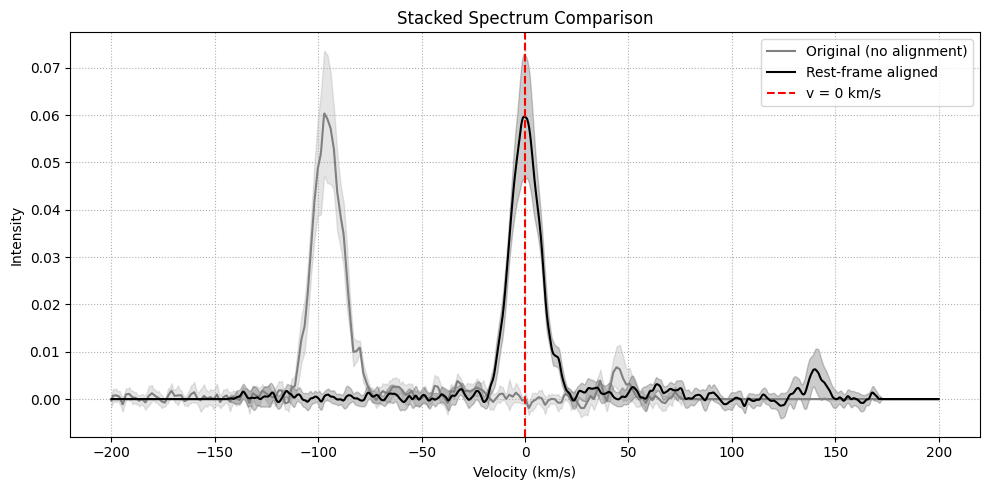

✅ Stacking comparison complete. Used 98 spectra.


In [20]:
def compare_stack_with_without_shift(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    v_range=(-50, 50),
    dv=0.2,
    normalize=False,
    min_valid_spectra=30
):
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import interp1d

    # === 讀取資料 ===
    with open(data_pickle, 'rb') as f:
        data = pickle.load(f)
    with open(result_pickle, 'rb') as f:
        result = pickle.load(f)

    x_all = data['x_values']
    y_all = data['data_list']
    amps_all = result['amplitudes_fit']
    means_all = result['means_fit']

    # === 建立速度網格 ===
    v_grid = np.arange(v_range[0], v_range[1] + dv, dv)
    stacked_shifted, stacked_direct = [], []
    used_count = 0

    for x, y, amps, means in zip(x_all, y_all, amps_all, means_all):
        if amps is None or means is None or len(amps) == 0:
            continue

        try:
            idx_peak = np.argmax(amps)
            v_peak = means[idx_peak]

            # --- 對齊後 ---
            x_shifted = x - v_peak
            interp_shifted = interp1d(x_shifted, y, kind='linear', bounds_error=False, fill_value=0)
            y_shifted = interp_shifted(v_grid)
            if normalize:
                max_val = np.nanmax(np.abs(y_shifted))
                if max_val > 0:
                    y_shifted /= max_val
            stacked_shifted.append(y_shifted)

            # --- 未對齊 ---
            interp_direct = interp1d(x, y, kind='linear', bounds_error=False, fill_value=0)
            y_direct = interp_direct(v_grid)
            if normalize:
                max_val = np.nanmax(np.abs(y_direct))
                if max_val > 0:
                    y_direct /= max_val
            stacked_direct.append(y_direct)

            used_count += 1
        except Exception:
            continue

    # === 轉為 numpy 陣列 ===
    stacked_shifted = np.array(stacked_shifted)
    stacked_direct = np.array(stacked_direct)

    # === 有效區間遮罩 ===
    valid_counts = np.sum(~np.isnan(stacked_shifted), axis=0)
    valid_mask = valid_counts >= min_valid_spectra
    v_grid_valid = v_grid[valid_mask]

    mean_shifted = np.nanmean(stacked_shifted[:, valid_mask], axis=0)
    std_shifted = np.nanstd(stacked_shifted[:, valid_mask], axis=0)

    mean_direct = np.nanmean(stacked_direct[:, valid_mask], axis=0)
    std_direct = np.nanstd(stacked_direct[:, valid_mask], axis=0)

    # === 繪圖 ===
    plt.figure(figsize=(10, 5))
    plt.plot(v_grid_valid, mean_direct, label='Original (no alignment)', color='gray', linestyle='-')
    plt.fill_between(v_grid_valid, mean_direct - std_direct, mean_direct + std_direct, color='gray', alpha=0.2)

    plt.plot(v_grid_valid, mean_shifted, label='Rest-frame aligned', color='black')
    plt.fill_between(v_grid_valid, mean_shifted - std_shifted, mean_shifted + std_shifted, color='black', alpha=0.2)

    plt.axvline(0, linestyle='--', color='red', label='v = 0 km/s')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Intensity')
    plt.title('Stacked Spectrum Comparison')
    plt.grid(True, linestyle=':')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"✅ Stacking comparison complete. Used {used_count} spectra.")

    return
        # 'v_grid': v_grid_valid,
        # 'mean_shifted': mean_shifted,
        # 'std_shifted': std_shifted,
        # 'mean_direct': mean_direct,
        # 'std_direct': std_direct,
        # 'used_count': used_count
    

compare_stack_with_without_shift(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    v_range=(-200,200),
    dv=0.2,
    normalize=False,
    min_valid_spectra=30
)

Prepared 400 spectra → spectrum_for_gausspy.pickle
Running GaussPy phase-two decomposition ...
using 6 out of 8 cpus
   ---->   0
   ---->   1   ---->  

  0%|          | 0.00/399 [00:00<?, ?it/s]

   ---->  
   ---->     32   ---->     ---->  
4
  
65

   ---->  

  0%|          | 1.00/399 [00:00<02:15, 2.93it/s]

 7
   ---->   8   ---->  
 9


  1%|          | 4.00/399 [00:00<00:36, 10.7it/s]

   ---->   10
   ---->     ---->    11
12


  2%|▏         | 7.00/399 [00:00<00:41, 9.37it/s]

   ---->   13
   ---->   14
   ---->   15
   ---->   16
   ---->   17


  3%|▎         | 12.0/399 [00:00<00:22, 17.2it/s]

   ---->   18
   ---->   19
   ---->   20


  4%|▍         | 15.0/399 [00:01<00:31, 12.4it/s]

   ---->   21
   ---->   22
   ---->   23
   ---->   24


  5%|▍         | 19.0/399 [00:01<00:30, 12.6it/s]

   ---->   25
   ---->   26
   ---->   27


  6%|▌         | 22.0/399 [00:01<00:26, 14.2it/s]

   ---->   28
   ---->   29
   ---->   30


  6%|▋         | 25.0/399 [00:02<00:29, 12.6it/s]

   ---->   31
   ---->   32
   ---->   33


  7%|▋         | 28.0/399 [00:02<00:24, 15.0it/s]

   ---->   34
   ---->   35


  8%|▊         | 30.0/399 [00:02<00:23, 15.5it/s]

   ---->   36
   ---->   37


  8%|▊         | 32.0/399 [00:02<00:27, 13.1it/s]

   ---->   38
   ---->   39
   ---->   40
   ---->   41
   ---->  

  9%|▉         | 36.0/399 [00:02<00:20, 17.6it/s]

 42
   ---->   43
   ---->   44
   ---->  

 10%|▉         | 39.0/399 [00:02<00:24, 14.6it/s]

 45
   ---->   46
   ---->   47
   ---->  

 11%|█         | 42.0/399 [00:02<00:20, 17.3it/s]

 48
   ---->   49
   ---->   50
   ---->  

 11%|█▏        | 45.0/399 [00:03<00:26, 13.3it/s]

 51
   ---->   52
   ---->   53
   ---->   54


 12%|█▏        | 49.0/399 [00:03<00:24, 14.1it/s]

   ---->   55
   ---->   56
   ---->  

 13%|█▎        | 51.0/399 [00:03<00:23, 14.6it/s]

 57
   ---->   58
   ---->   59
   ---->  

 14%|█▎        | 54.0/399 [00:03<00:20, 16.6it/s]

 60
   ---->   61


 14%|█▍        | 56.0/399 [00:04<00:25, 13.6it/s]

   ---->   62
   ---->   63
   ---->   64
   ---->   65


 15%|█▌        | 60.0/399 [00:04<00:19, 17.0it/s]

   ---->   66
   ---->   67


 16%|█▌        | 62.0/399 [00:04<00:23, 14.2it/s]

   ---->   68
   ---->   69
   ---->   70
   ---->   71


 17%|█▋        | 66.0/399 [00:04<00:20, 16.2it/s]

   ---->   72
   ---->   73
   ---->  

 17%|█▋        | 68.0/399 [00:04<00:25, 13.1it/s]

 74
   ---->   75
   ---->   76
   ---->   77
   ---->  

 18%|█▊        | 72.0/399 [00:05<00:22, 14.2it/s]

 78
   ---->   79


 19%|█▊        | 74.0/399 [00:05<00:23, 14.1it/s]

   ---->   80
   ---->   81
   ---->   82
   ---->   83


 20%|█▉        | 78.0/399 [00:05<00:21, 14.7it/s]

   ---->   84
   ---->   85


 20%|██        | 80.0/399 [00:05<00:21, 14.9it/s]

   ---->   86
   ---->   87
   ---->   88
   ---->   89


 21%|██        | 84.0/399 [00:05<00:22, 14.1it/s]

   ---->   90   ---->  
 91


 22%|██▏       | 86.0/399 [00:06<00:21, 14.7it/s]

   ---->   92
   ---->   93
   ---->   94


 22%|██▏       | 89.0/399 [00:06<00:18, 17.1it/s]

   ---->   95
   ---->   96
   ---->  

 23%|██▎       | 91.0/399 [00:06<00:23, 13.1it/s]

 97
   ---->   98


 23%|██▎       | 93.0/399 [00:06<00:23, 13.2it/s]

   ---->      ---->  99 
100
   ---->   101
   ---->  

 24%|██▍       | 96.0/399 [00:06<00:24, 12.1it/s]

    ---->  102 103

   ---->   104


 25%|██▍       | 99.0/399 [00:07<00:21, 13.7it/s]

   ---->   105
   ---->   106
   ---->   107
   ---->  

 26%|██▌       | 102/399 [00:07<00:22, 13.2it/s] 

 108
   ---->   109


 26%|██▌       | 104/399 [00:07<00:21, 13.6it/s]

   ---->   110
   ---->   111


 27%|██▋       | 106/399 [00:07<00:21, 13.8it/s]

   ---->   112
   ---->   113
   ---->  

 27%|██▋       | 108/399 [00:07<00:22, 13.1it/s]

 114
   ---->   115
   ---->   116
   ---->  

 28%|██▊       | 111/399 [00:07<00:18, 15.9it/s]

 117
   ---->   118
   ---->  

 28%|██▊       | 113/399 [00:07<00:18, 15.8it/s]

 119
   ---->   120
   ---->  

 29%|██▉       | 115/399 [00:08<00:19, 14.4it/s]

 121
   ---->   122


 29%|██▉       | 117/399 [00:08<00:26, 10.6it/s]

   ---->   123
   ---->   124
   ---->   125


 30%|███       | 120/399 [00:08<00:26, 10.7it/s]

   ---->   126
   ---->   127
   ---->   128
   ---->  

 31%|███       | 123/399 [00:08<00:22, 12.4it/s]

 129
   ---->   130
   ---->   131


 32%|███▏      | 126/399 [00:09<00:21, 12.7it/s]

   ---->   132
   ---->   133


 32%|███▏      | 128/399 [00:09<00:20, 13.5it/s]

   ---->   134
   ---->   135


 33%|███▎      | 130/399 [00:09<00:19, 14.0it/s]

   ---->   136
   ---->   137


 33%|███▎      | 132/399 [00:09<00:20, 12.9it/s]

   ---->   138
   ---->   139


 34%|███▎      | 134/399 [00:09<00:19, 13.7it/s]

   ---->   140
   ---->   141


 34%|███▍      | 136/399 [00:09<00:18, 14.4it/s]

   ---->   142
   ---->   143


 35%|███▍      | 138/399 [00:10<00:32, 8.12it/s]

   ---->   144
   ---->   145   ---->  
 146


 35%|███▌      | 141/399 [00:10<00:26, 9.64it/s]

   ---->   147
   ---->   148
   ---->   149
   ---->  

 36%|███▌      | 144/399 [00:10<00:22, 11.1it/s]

 150
   ---->   151
   ---->   152


 37%|███▋      | 147/399 [00:10<00:21, 11.9it/s]

   ---->   153
   ---->   154


 37%|███▋      | 149/399 [00:11<00:20, 12.0it/s]

   ---->   155
   ---->   156
   ---->      ---->  157 
158
   ---->  

 38%|███▊      | 153/399 [00:11<00:19, 12.8it/s]

 159
   ---->   160
   ---->  

 39%|███▉      | 155/399 [00:11<00:18, 13.0it/s]

 161
   ---->   162


 39%|███▉      | 157/399 [00:11<00:24, 10.1it/s]

   ---->   163
   ---->   164
   ---->  

 40%|███▉      | 159/399 [00:12<00:27, 8.83it/s]

 165
   ---->   166
   ---->   167


 41%|████      | 162/399 [00:12<00:21, 11.1it/s]

   ---->   168   ---->   
169


 41%|████      | 164/399 [00:12<00:20, 11.5it/s]

   ---->   170
   ---->   171


 42%|████▏     | 166/399 [00:12<00:20, 11.2it/s]

   ---->   172
   ---->   173
   ---->   174
   ---->   175


 43%|████▎     | 170/399 [00:12<00:17, 13.1it/s]

   ---->   176
   ---->   177

 43%|████▎     | 172/399 [00:13<00:17, 13.1it/s]

   ---->  
 178
   ---->   179


 44%|████▎     | 174/399 [00:13<00:15, 14.1it/s]

   ---->   180
   ---->   181


 44%|████▍     | 176/399 [00:13<00:22, 9.74it/s]

   ---->   182
   ---->     ---->    183184



 45%|████▍     | 179/399 [00:13<00:22, 9.61it/s]

   ---->     ---->    185186



 45%|████▌     | 181/399 [00:14<00:20, 10.7it/s]

   ---->   187
   ---->   188
   ---->   189
   ---->   190


 46%|████▋     | 185/399 [00:14<00:19, 11.1it/s]

   ---->   191   ---->   
192
   ---->   193
   ---->   194


 47%|████▋     | 189/399 [00:14<00:13, 15.1it/s]

   ---->   195
   ---->   196


 48%|████▊     | 191/399 [00:14<00:18, 11.5it/s]

   ---->   197
   ---->   198
   ---->   199
   ---->   200


 49%|████▉     | 195/399 [00:14<00:13, 15.3it/s]

   ---->   201
   ---->   202
   ---->   203


 50%|████▉     | 198/399 [00:15<00:17, 11.4it/s]

   ---->   204
   ---->   205


 50%|█████     | 200/399 [00:15<00:18, 11.0it/s]

   ---->   206
   ---->   207
   ---->  

 51%|█████     | 202/399 [00:15<00:16, 12.0it/s]

 208
   ---->   209


 51%|█████     | 204/399 [00:15<00:16, 11.9it/s]

   ---->   210
   ---->   211


 52%|█████▏    | 206/399 [00:16<00:16, 11.5it/s]

   ---->   212
   ---->   213


 52%|█████▏    | 208/399 [00:16<00:16, 11.8it/s]

   ---->   214
   ---->   215
   ---->  

 53%|█████▎    | 210/399 [00:16<00:14, 13.0it/s]

 216
   ---->   217
   ---->  

 53%|█████▎    | 212/399 [00:16<00:14, 13.0it/s]

 218
   ---->   219
   ---->  

 54%|█████▎    | 214/399 [00:16<00:15, 12.2it/s]

 220
   ---->   221


 54%|█████▍    | 216/399 [00:16<00:15, 11.8it/s]

   ---->   222
   ---->   223


 55%|█████▍    | 218/399 [00:17<00:16, 10.8it/s]

   ---->   224
   ---->   225
   ---->   226
   ---->  

 55%|█████▌    | 221/399 [00:17<00:14, 12.3it/s]

 227
   ---->   228


 56%|█████▌    | 223/399 [00:17<00:17, 10.3it/s]

   ---->   229
   ---->   230
   ---->   231
   ---->  

 57%|█████▋    | 226/399 [00:17<00:13, 12.6it/s]

 232
   ---->   233
   ---->   234


 57%|█████▋    | 229/399 [00:17<00:14, 11.9it/s]

   ---->   235
   ---->   236
   ---->  

 58%|█████▊    | 231/399 [00:18<00:12, 13.1it/s]

 237
   ---->   238   ---->  
 239


 59%|█████▊    | 234/399 [00:18<00:10, 15.2it/s]

   ---->   240
   ---->   241


 59%|█████▉    | 236/399 [00:18<00:15, 10.7it/s]

   ---->   242
   ---->   243
   ---->   244


 60%|█████▉    | 239/399 [00:18<00:12, 12.7it/s]

   ---->   245
   ---->   246


 60%|██████    | 241/399 [00:18<00:12, 12.8it/s]

   ---->   247
   ---->   248
   ---->  

 61%|██████    | 243/399 [00:19<00:13, 11.2it/s]

 249
   ---->   250


 61%|██████▏   | 245/399 [00:19<00:12, 12.6it/s]

   ---->   251
   ---->   252


 62%|██████▏   | 247/399 [00:19<00:11, 12.8it/s]

   ---->   253
   ---->   254
   ---->  

 62%|██████▏   | 249/399 [00:19<00:11, 12.5it/s]

 255
   ---->   256


 63%|██████▎   | 251/399 [00:19<00:11, 13.2it/s]

   ---->   257
   ---->   258


 63%|██████▎   | 253/399 [00:19<00:10, 14.5it/s]

   ---->   259
   ---->   260


 64%|██████▍   | 255/399 [00:19<00:11, 12.7it/s]

   ---->   261
   ---->   262


 64%|██████▍   | 257/399 [00:20<00:15, 9.42it/s]

   ---->   263
   ---->   264
   ---->  

 65%|██████▍   | 259/399 [00:20<00:12, 11.0it/s]

 265
   ---->   266
   ---->  

 65%|██████▌   | 261/399 [00:20<00:11, 12.1it/s]

 267
   ---->   268
   ---->  

 66%|██████▌   | 263/399 [00:20<00:13, 10.3it/s]

 269
   ---->   270


 66%|██████▋   | 265/399 [00:20<00:11, 11.6it/s]

   ---->   271
   ---->   272


 67%|██████▋   | 267/399 [00:21<00:10, 13.2it/s]

   ---->   273
   ---->   274


 67%|██████▋   | 269/399 [00:21<00:10, 11.9it/s]

   ---->   275
   ---->   276
   ---->  

 68%|██████▊   | 271/399 [00:21<00:10, 12.2it/s]

 277
   ---->   278
   ---->   279


 69%|██████▊   | 274/399 [00:21<00:08, 15.1it/s]

   ---->   280
   ---->   281


 69%|██████▉   | 276/399 [00:21<00:11, 10.7it/s]

   ---->   282
   ---->   283
   ---->  

 70%|██████▉   | 278/399 [00:22<00:12, 9.67it/s]

 284
   ---->   285
   ---->   286


 70%|███████   | 281/399 [00:22<00:09, 11.9it/s]

   ---->   287
   ---->   288
   ---->  

 71%|███████   | 283/399 [00:22<00:10, 11.1it/s]

 289
   ---->   290


 71%|███████▏  | 285/399 [00:22<00:10, 10.8it/s]

   ---->   291
   ---->   292
   ---->   293


 72%|███████▏  | 288/399 [00:22<00:07, 14.1it/s]

   ---->   294
   ---->   295
   ---->  

 73%|███████▎  | 290/399 [00:23<00:09, 11.9it/s]

 296
   ---->   297


 73%|███████▎  | 292/399 [00:23<00:08, 12.4it/s]

   ---->   298
   ---->   299
   ---->   300


 74%|███████▍  | 295/399 [00:23<00:07, 13.9it/s]

   ---->   301
   ---->   302

 74%|███████▍  | 297/399 [00:23<00:10, 9.85it/s]

   ---->  
 303
   ---->   304
   ---->   305
   ---->  

 75%|███████▌  | 300/399 [00:23<00:08, 11.0it/s]

 306
   ---->   307


 76%|███████▌  | 302/399 [00:24<00:09, 10.5it/s]

   ---->   308
   ---->   309


 76%|███████▌  | 304/399 [00:24<00:08, 11.4it/s]

   ---->   310
   ---->   311


 77%|███████▋  | 306/399 [00:24<00:07, 11.8it/s]

   ---->   312
   ---->   313
   ---->  

 77%|███████▋  | 308/399 [00:24<00:08, 11.1it/s]

 314
   ---->   315
   ---->   316
   ---->  

 78%|███████▊  | 311/399 [00:24<00:06, 13.5it/s]

 317
   ---->   318


 78%|███████▊  | 313/399 [00:24<00:06, 13.2it/s]

   ---->   319
   ---->   320


 79%|███████▉  | 315/399 [00:25<00:07, 11.8it/s]

   ---->   321
   ---->   322


 79%|███████▉  | 317/399 [00:25<00:09, 8.89it/s]

   ---->   323
   ---->   324
   ---->  

 80%|███████▉  | 319/399 [00:25<00:08, 9.69it/s]

 325
   ---->   326


 80%|████████  | 321/399 [00:25<00:07, 10.8it/s]

   ---->   327
   ---->   328


 81%|████████  | 323/399 [00:26<00:07, 10.5it/s]

   ---->   329
   ---->   330


 81%|████████▏ | 325/399 [00:26<00:06, 11.2it/s]

   ---->   331
   ---->   332


 82%|████████▏ | 327/399 [00:26<00:06, 11.3it/s]

   ---->   333
   ---->   334


 82%|████████▏ | 329/399 [00:26<00:05, 12.5it/s]

   ---->   335
   ---->   336


 83%|████████▎ | 331/399 [00:26<00:05, 12.1it/s]

   ---->   337
   ---->   338


 83%|████████▎ | 333/399 [00:26<00:05, 11.9it/s]

   ---->   339
   ---->   340


 84%|████████▍ | 335/399 [00:27<00:07, 8.70it/s]

   ---->   341
   ---->   342


 84%|████████▍ | 337/399 [00:27<00:07, 7.86it/s]

   ---->   343
   ---->   344


 85%|████████▍ | 339/399 [00:27<00:06, 9.04it/s]

   ---->   345
   ---->   346


 85%|████████▌ | 341/399 [00:27<00:06, 9.27it/s]

   ---->   347
   ---->   348


 86%|████████▌ | 343/399 [00:28<00:05, 10.0it/s]

   ---->   349
   ---->   350
   ---->  

 86%|████████▋ | 345/399 [00:28<00:05, 10.2it/s]

    ---->  351
 352
   ---->   353


 87%|████████▋ | 348/399 [00:28<00:03, 13.3it/s]

   ---->   354
   ---->   355
   ---->  

 88%|████████▊ | 350/399 [00:28<00:04, 11.4it/s]

 356
   ---->   357


 88%|████████▊ | 352/399 [00:28<00:03, 12.9it/s]

   ---->   358
   ---->   359


 89%|████████▊ | 354/399 [00:28<00:03, 14.0it/s]

   ---->   360
   ---->   361
   ---->  

 89%|████████▉ | 356/399 [00:29<00:04, 8.62it/s]

 362
   ---->   363


 90%|████████▉ | 358/399 [00:29<00:05, 7.45it/s]

   ---->   364
   ---->   365
   ---->   366
   ---->  

 90%|█████████ | 361/399 [00:29<00:03, 10.4it/s]

 367
   ---->   368


 91%|█████████ | 363/399 [00:29<00:03, 9.26it/s]

   ---->   369
   ---->   370


 91%|█████████▏| 365/399 [00:30<00:03, 10.2it/s]

   ---->     ---->    372371

   ---->   373
   ---->   374


 92%|█████████▏| 369/399 [00:30<00:02, 11.1it/s]

   ---->   375
   ---->   376


 93%|█████████▎| 371/399 [00:30<00:02, 11.9it/s]

   ---->   377
   ---->     ---->    379378

   ---->   380


 94%|█████████▍| 375/399 [00:30<00:02, 11.9it/s]

   ---->   381
   ---->   382


 94%|█████████▍| 377/399 [00:31<00:01, 12.0it/s]

   ---->   383   ---->   
384
   ---->   385


 95%|█████████▌| 380/399 [00:31<00:01, 11.9it/s]

   ---->   386
   ---->   387
   ---->     ---->  

 96%|█████████▌| 382/399 [00:31<00:01, 11.2it/s]

  388389

   ---->   390
   ---->   391


 97%|█████████▋| 386/399 [00:31<00:01, 11.8it/s]

   ---->   392
   ---->   393


 97%|█████████▋| 388/399 [00:31<00:00, 12.1it/s]

   ---->   394
   ---->   395
   ---->   396


 98%|█████████▊| 391/399 [00:32<00:00, 15.0it/s]

   ---->   397
   ---->   398


 98%|█████████▊| 393/399 [00:32<00:00, 12.5it/s]

   ---->   399


100%|██████████| 399/399 [00:32<00:00, 12.2it/s]
399it [00:00, 852535.56it/s]

SUCCESS
100 finished.%
GaussPy decomposition finished → gausspy_result.pickle
Result keys: ['index_fit', 'amplitudes_fit', 'fwhms_fit', 'means_fit', 'index_initial', 'amplitudes_initial', 'fwhms_initial', 'means_initial', 'amplitudes_fit_err', 'fwhms_fit_err', 'means_fit_err', 'best_fit_rchi2', 'amplitudes_fit_em', 'fwhms_fit_em', 'means_fit_em', 'means_fit_err_em', 'amplitudes_fit_err_em', 'fwhms_fit_err_em', 'fit_labels']
Total: 400, Success: 296, Failed: 104
Success rate: 74.0%


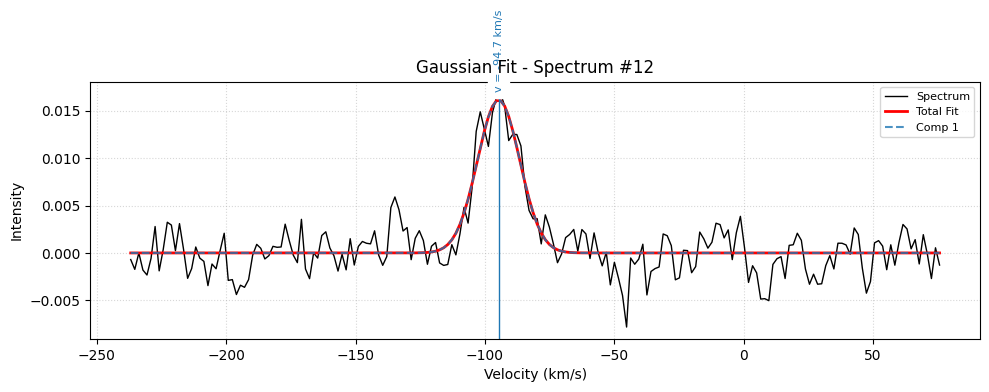

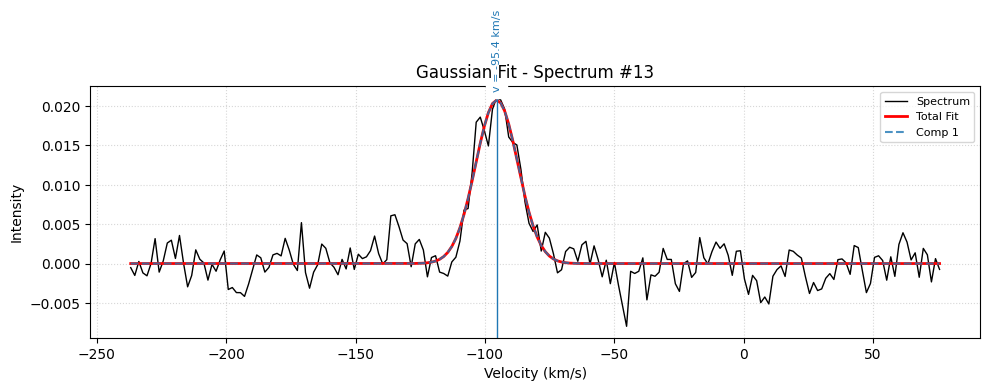

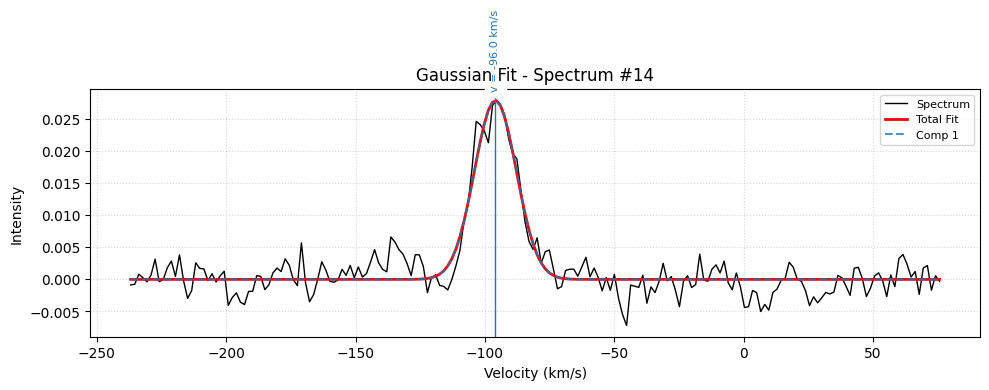

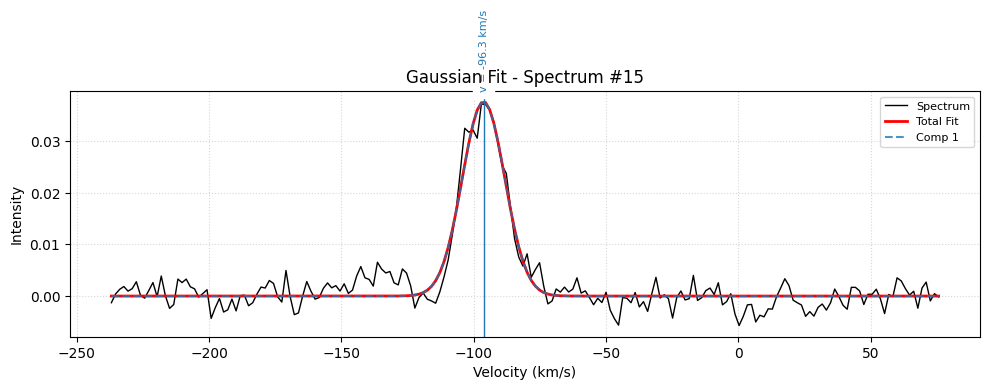

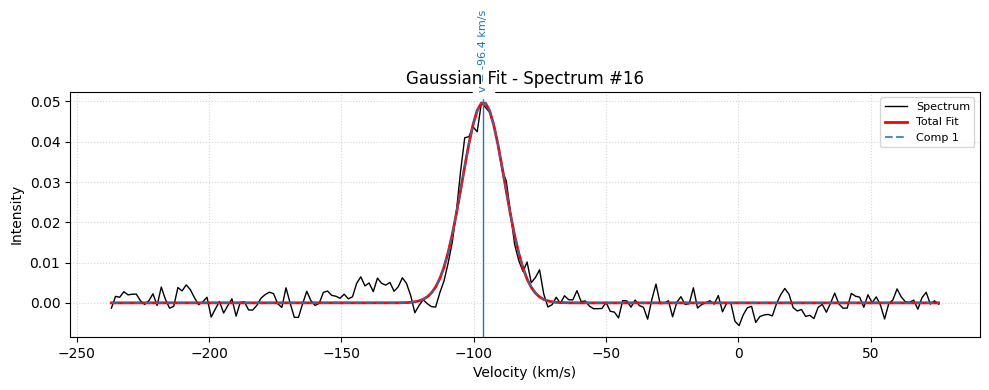

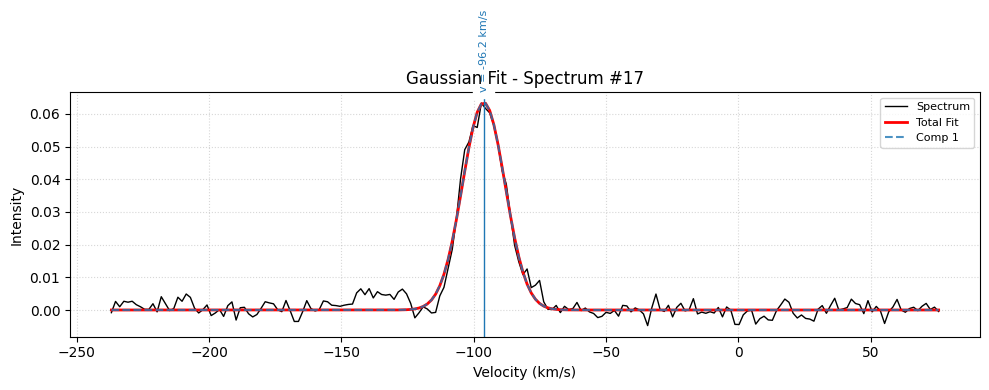

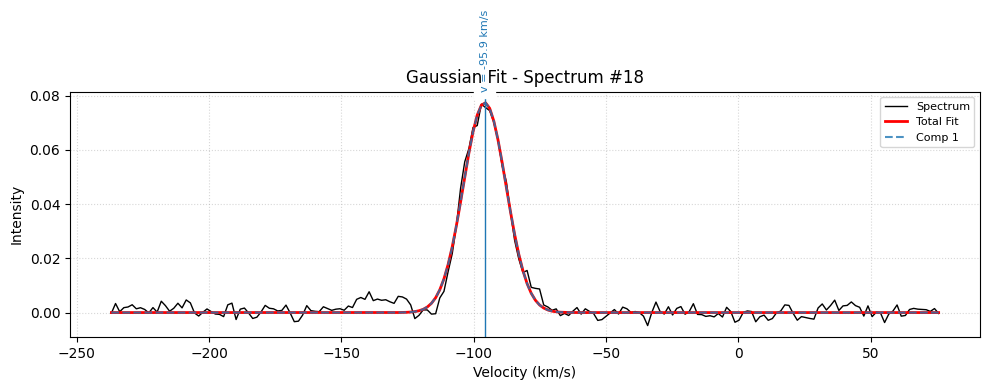

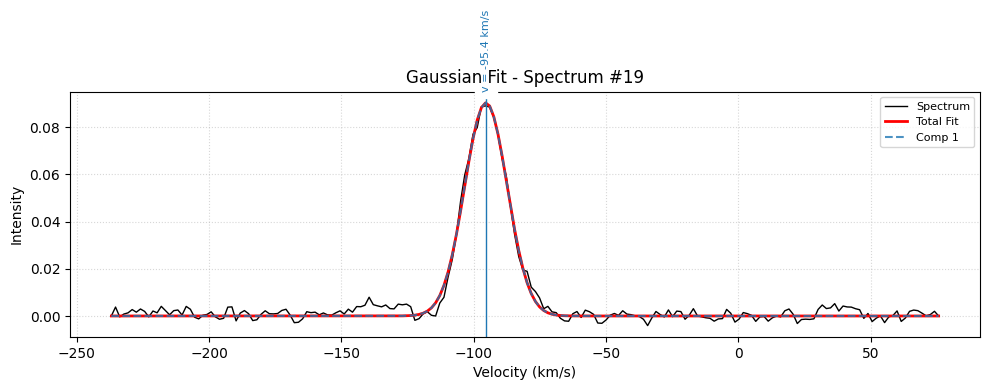

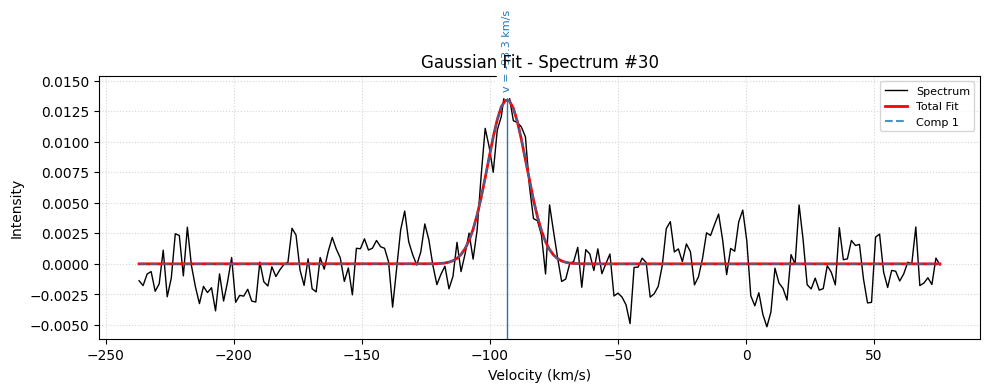

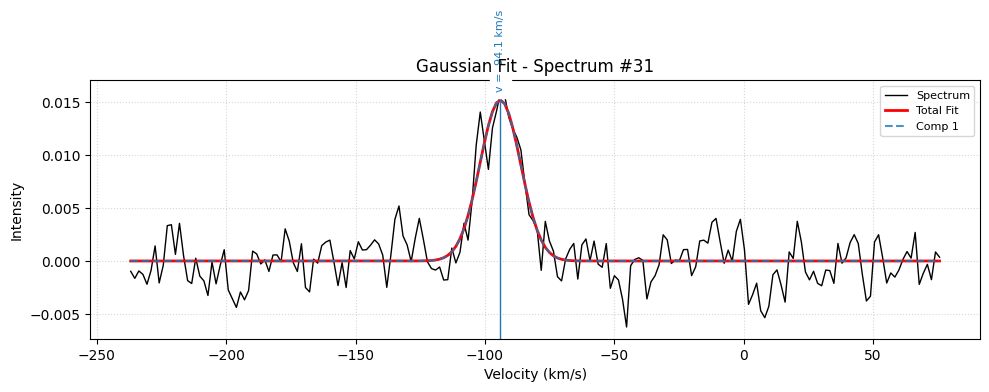

Plotted 10 fitted spectra.


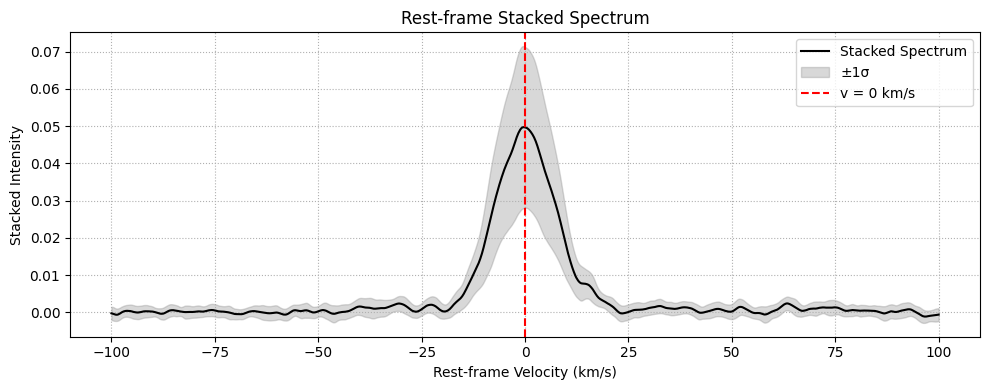

Stacking done: 296/400 spectra used (74.0%)


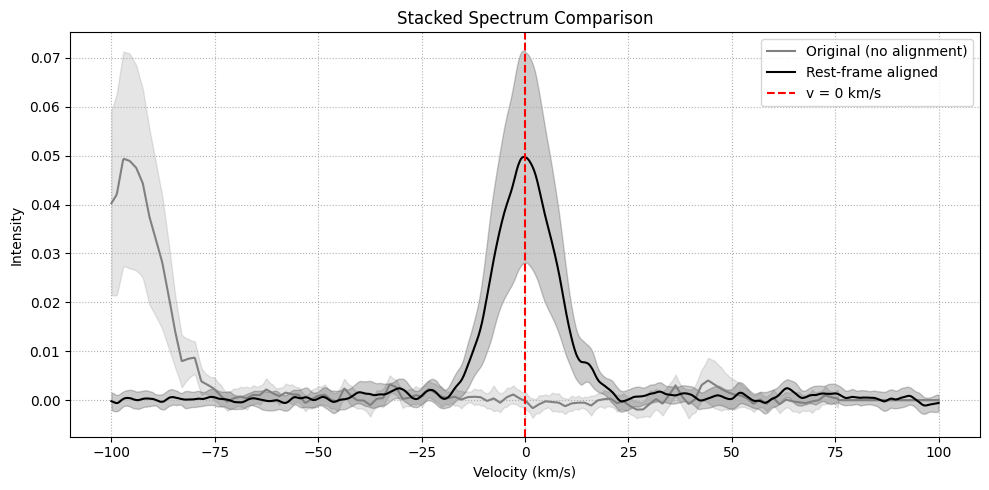

Stacking comparison done. Used 296 spectra.


In [5]:
from gausspy_pipeline import GausspyPipeline

# 依據你的資料設定下列參數
pipeline = GausspyPipeline(
    cube_file='../datacubes/spw0.fits',    # 你的 FITS 檔案
    v1=750, v2=950,           # 頻道範圍
    x1=220, x2=240,           # x 空間範圍
    y1=100, y2=120,           # y 空間範圍
    alpha1=2.5,
    alpha2=7.0,
    snr_thresh=4.0
)

# Step 1: 準備 spectra pickle
pipeline.prepare_input()

# Step 2: 跑 GaussPy decomposition
pipeline.run_decomposition()

# Step 3: 統計分解成效
pipeline.count_fits()

# Step 4: 繪製部分擬合圖（預設最多10條）
pipeline.plot_fits()

# Step 5: Rest-frame 疊加分析、繪圖
pipeline.stack_restframe()

# Step 6: 疊加比較（可省略）
pipeline.compare_stack()
